In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from transformers import DistilBertConfig, DistilBertModel, DistilBertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn
import os
import pickle as pkl
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import regex as re  
import warnings
warnings.filterwarnings('ignore')

1.3.2


In [4]:
df = pd.read_csv("./IMDB Dataset.csv")

df["sentiment"], sentiment_labels = pd.factorize(df["sentiment"])
# Random seed for reproducibility
RANDOM_SEED = 42


In [5]:
MAX_LEN = 512

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)

In [7]:

df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)

print(df_train.shape, df_test.shape)

(40000, 2) (10000, 2)


In [9]:
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased', return_dict=False)

In [10]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = bert_model
        self.pre_classifier = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size)
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        # Obtain the last hidden states from the DistilBert model
        last_hidden_state = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[0]  # Take the first element of the tuple which is the last_hidden_state

        # Apply a linear layer and dropout
        pooled_output = self.pre_classifier(last_hidden_state[:, 0])  # Use the first token's embeddings for pooling
        pooled_output = nn.ReLU()(pooled_output)  # Use a ReLU activation function
        pooled_output = self.dropout(pooled_output)
        # Pass the output of the dropout layer to the output layer
        return self.out(pooled_output)

In [11]:
model_checkpoint = "./distiloberto_512t.bin"
model = SentimentClassifier(n_classes=2)
device = torch.device("cuda:0")
model.load_state_dict(torch.load(model_checkpoint, map_location=device))
model.to(device)
model.eval()

SentimentClassifier(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Lin

In [12]:
def preprocess(text):
    max_len = 512
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    return encoding['input_ids'].to(device), encoding['attention_mask'].to(device)

In [13]:
def predict_sentiment(text):
    input_ids, attention_mask = preprocess(text)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # The output is logits, we need to take softmax to get probabilities
        probs = torch.nn.functional.softmax(outputs, dim=1)
        # Taking the class with the highest probability
        prediction = torch.argmax(probs, dim=1)
        return prediction.to("cpu").item()

In [51]:
user_input = input("Input: ")
prediction = predict_sentiment(user_input)
print("Prediction: ", sentiment_labels[prediction])

Prediction:  negative


In [14]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

In [15]:
test_predictions = []
for text in tqdm(df_test['review']):
    test_predictions.append(predict_sentiment(text))

100%|██████████| 10000/10000 [03:21<00:00, 49.65it/s]


In [16]:
# Convert test_predictions to a DataFrame
df_test_predictions = pd.DataFrame({'test_predictions': test_predictions})

# Save the DataFrame to disk
df_test_predictions.to_csv('test_predictions.csv', index=False)


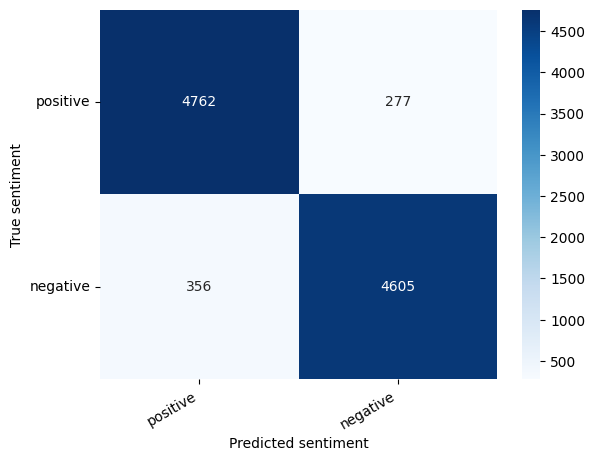

In [17]:
# Convert predictions to numpy array
y_pred = np.array(test_predictions)

# Convert true labels to numpy array
y_test = df_test['sentiment'].values

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=sentiment_labels, columns=sentiment_labels)
show_confusion_matrix(df_cm)

Accuracy: 0.9367
Precision: 0.9368012731010663
Recall: 0.9367
F1 Score: 0.9366921469653054


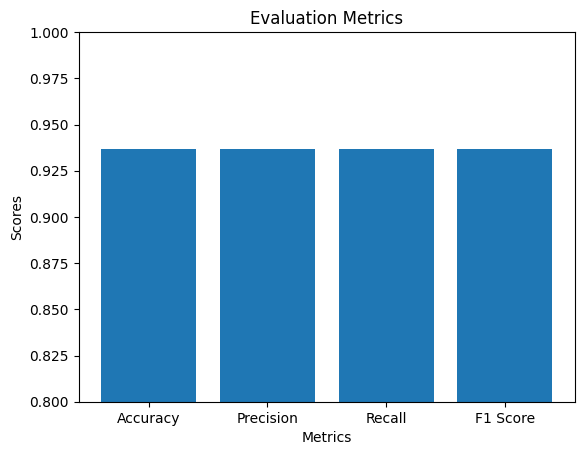

In [29]:
from sklearn.metrics import classification_report

# Calculate accuracy, precision, recall, and F1 score
report = classification_report(y_test, y_pred, target_names=sentiment_labels, output_dict=True)

# Extract the metrics
accuracy = report['accuracy']
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)
import matplotlib.pyplot as plt

# Define the scores and their labels
scores = [accuracy, precision, recall, f1_score]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Define the scores and their labels
scores = [accuracy, precision, recall, f1_score]
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Set the range for the y-axis
plt.ylim(0.8, 1.0)

# Create a bar plot
plt.bar(labels, scores)

# Add labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Evaluation Metrics')

# Display the plot
plt.show()


